In [1]:
# Colab setup with pinned transformers version
import sys
if 'google.colab' in sys.modules:
    !pip install transformers datasets accelerate scikit-learn seaborn --quiet
    from google.colab import drive
    drive.mount('/content/drive')  # Optional if using Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Essential Imports
import os
import json
import logging
import warnings
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)


from datasets import Dataset as HFDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # FIXED from _name_

In [4]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [5]:
class Config:
    """Configuration class for hyperparameters and paths"""
    # Data paths (adjust for your Colab setup)
    DATA_PATH = "/content/drive/MyDrive/saved_data"
    OUTPUT_DIR = "/content/results"
    MODEL_DIR = "/content/fine_tuned_model"

    # Model hyperparameters
    MODEL_NAME = "distilbert-base-uncased"
    MAX_LENGTH = 512
    BATCH_SIZE = 8  # Optimized for T4
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 3
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.01

    # Training parameters
    VALIDATION_SPLIT = 0.15
    TEST_SPLIT = 0.15
    EARLY_STOPPING_PATIENCE = 1
    SAVE_STEPS = 1000
    EVAL_STEPS = 500
    LOGGING_STEPS = 100

    # GPU optimization
    FP16 = False  # T4 not optimal for mixed precision — you can try True
    DATALOADER_NUM_WORKERS = 0

In [6]:
class CategoryMapper:
    """Handles category mapping and normalization"""

    CATEGORY_MAPPING = {
        "cs": "Computer Science",
        "econ": "Economics",
        "eess": "Electrical Engineering and Systems Science",
        "math": "Mathematics",
        "astro-ph": "Physics",
        "cond-mat": "Physics",
        "gr-qc": "Physics",
        "hep-ex": "Physics",
        "hep-lat": "Physics",
        "hep-ph": "Physics",
        "hep-th": "Physics",
        "math-ph": "Physics",
        "nlin": "Physics",
        "nucl-ex": "Physics",
        "nucl-th": "Physics",
        "physics": "Physics",
        "quant-ph": "Physics",
        "q-bio": "Quantitative Biology",
        "q-fin": "Quantitative Finance",
        "stat": "Statistics"
    }

    @classmethod
    def get_main_category(cls, categories: str) -> str:
        """Extract main category from categories string"""
        if not categories:
            return "Unknown"

        # Take first category
        main_cat = categories.split()[0].lower()
        prefix = main_cat.split(".")[0]

        # Handle multi-part categories
        if prefix in ["astro-ph", "cond-mat", "hep-ex", "hep-lat", "hep-ph", "hep-th",
                      "math-ph", "nucl-ex", "nucl-th", "quant-ph"]:
            return cls.CATEGORY_MAPPING.get(prefix, "Unknown")

        return cls.CATEGORY_MAPPING.get(prefix, "Unknown")

In [7]:
class ArXivDataProcessor:
    """Handles data loading and preprocessing"""

    def __init__(self, config: Config):
        self.config = config
        self.label_encoder = LabelEncoder()

    def load_data_from_files(self, data_path: str) -> List[Dict]:
        """Load data from JSON/JSONL files"""
        records = []

        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data path {data_path} not found")

        logger.info(f"Loading data from {data_path}")

        for root, dirs, files in os.walk(data_path):
            for file in files:
                if file.endswith(('.txt', '.jsonl', '.json')):
                    file_path = os.path.join(root, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            for line_num, line in enumerate(f):
                                try:
                                    record = json.loads(line.strip())
                                    if self._is_valid_record(record):
                                        processed_record = self._process_record(record)
                                        if processed_record:
                                            records.append(processed_record)
                                except json.JSONDecodeError:
                                    logger.warning(f"Invalid JSON in {file}:{line_num}")
                                    continue
                    except Exception as e:
                        logger.error(f"Error reading {file_path}: {e}")
                        continue

        logger.info(f"Loaded {len(records)} valid records")
        return records

    def _is_valid_record(self, record: Dict) -> bool:
        """Check if record has required fields"""
        required_fields = ['title', 'summary', 'categories']
        return all(field in record and record[field] for field in required_fields)

    def _process_record(self, record: Dict) -> Dict:
        """Process individual record"""
        # Get main category
        main_category = CategoryMapper.get_main_category(record.get('categories', ''))

        if main_category == "Unknown":
            return None

        # Combine title and abstract
        title = record.get('title', '').strip()
        summary = record.get('summary', '').strip()


        text = f"{title} {summary}".strip()

        if len(text) < 10:  # Filter very short texts
            return None

        return {
            'text': text,
            'category': main_category,
            'id': record.get('id', ''),
            'title': title
        }

    def prepare_datasets(self, records: List[Dict]) -> Tuple[HFDataset, HFDataset, HFDataset]:
        """Prepare train, validation, and test datasets"""
        logger.info("Preparing datasets...")

        # Convert to DataFrame for easier manipulation
        df = pd.DataFrame(records)

        # Remove duplicates
        df = df.drop_duplicates(subset=['text'])
        logger.info(f"After deduplication: {len(df)} records")

        # Filter categories with too few samples
        category_counts = df['category'].value_counts()
        min_samples = 100  # Minimum samples per category
        valid_categories = category_counts[category_counts >= min_samples].index
        df = df[df['category'].isin(valid_categories)]
        logger.info(f"After filtering categories: {len(df)} records, {len(valid_categories)} categories")

        # Encode labels
        self.label_encoder.fit(df['category'])
        df['labels'] = self.label_encoder.transform(df['category'])

        # Split data: train/val/test
        train_df, temp_df = train_test_split(
            df,
            test_size=self.config.VALIDATION_SPLIT + self.config.TEST_SPLIT,
            stratify=df['labels'],
            random_state=42
        )

        val_df, test_df = train_test_split(
            temp_df,
            test_size=self.config.TEST_SPLIT / (self.config.VALIDATION_SPLIT + self.config.TEST_SPLIT),
            stratify=temp_df['labels'],
            random_state=24
        )

        logger.info(f"Dataset splits - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

        # Convert to HuggingFace datasets
        train_dataset = HFDataset.from_pandas(train_df[['text', 'labels']])
        val_dataset = HFDataset.from_pandas(val_df[['text', 'labels']])
        test_dataset = HFDataset.from_pandas(test_df[['text', 'labels']])

        return train_dataset, val_dataset, test_dataset

    def save_label_mapping(self, output_dir: str):
        """Save label mapping for later use"""
        os.makedirs(output_dir, exist_ok=True)
        mapping = {i: label for i, label in enumerate(self.label_encoder.classes_)}

        with open(os.path.join(output_dir, 'label_mapping.json'), 'w') as f:
            json.dump(mapping, f, indent=2)

        logger.info(f"Label mapping saved: {mapping}")

In [8]:
class ArXivTrainer:
    """Handles model training and evaluation"""

    def __init__(self, config: Config, num_labels: int):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Using device: {self.device}")

        # Initialize tokenizer and model
        self.tokenizer = DistilBertTokenizer.from_pretrained(config.MODEL_NAME)
        self.model = DistilBertForSequenceClassification.from_pretrained(
            config.MODEL_NAME,
            num_labels=num_labels
        )

        # Move model to GPU
        self.model.to(self.device)

    def tokenize_function(self, examples):
        """Tokenization function for datasets"""
        return self.tokenizer(
            examples['text'],
            truncation=True,
            padding=True,
            max_length=self.config.MAX_LENGTH
        )

    def prepare_datasets(self, train_dataset, val_dataset, test_dataset):
        """Tokenize datasets"""
        logger.info("Tokenizing datasets...")

        train_dataset = train_dataset.map(self.tokenize_function, batched=True)
        val_dataset = val_dataset.map(self.tokenize_function, batched=True)
        test_dataset = test_dataset.map(self.tokenize_function, batched=True)

        # Set format for PyTorch
        train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
        test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

        return train_dataset, val_dataset, test_dataset

    def compute_metrics(self, eval_pred):
        """Compute metrics for evaluation"""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        accuracy = accuracy_score(labels, predictions)
        return {"accuracy": accuracy}

    def train(self, train_dataset, val_dataset):
        """Train the model"""
        logger.info("Starting training...")

       # Training arguments optimized for A100 GPU
        training_args = TrainingArguments(
          output_dir=self.config.OUTPUT_DIR,
          num_train_epochs=self.config.NUM_EPOCHS,
          per_device_train_batch_size=32,  # Increased for A100's large memory
          per_device_eval_batch_size=32,
          warmup_steps=self.config.WARMUP_STEPS,
          weight_decay=self.config.WEIGHT_DECAY,
          learning_rate=self.config.LEARNING_RATE,
          logging_dir=f'{self.config.OUTPUT_DIR}/logs',
          logging_steps=self.config.LOGGING_STEPS,
          eval_strategy="epoch",
          eval_steps=self.config.EVAL_STEPS,
          save_strategy="epoch",
          save_steps=self.config.SAVE_STEPS,
          load_best_model_at_end=True,
          metric_for_best_model="accuracy",
          greater_is_better=True,
          bf16=True,
          fp16=False,
          dataloader_num_workers=self.config.DATALOADER_NUM_WORKERS,
          remove_unused_columns=False,
          push_to_hub=False,
          gradient_accumulation_steps=1,
          report_to="none",
      )

        # Data collator
        data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)

        # Initialize trainer
        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=self.compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=self.config.EARLY_STOPPING_PATIENCE)]
        )

        # Train
        train_result = self.trainer.train()

        # Save model
        self.trainer.save_model(self.config.MODEL_DIR)
        self.tokenizer.save_pretrained(self.config.MODEL_DIR)

        logger.info("Training completed!")
        return train_result

    def evaluate(self, test_dataset, label_encoder):
        """Evaluate model on test set"""
        logger.info("Evaluating on test set...")

        test_results = self.trainer.evaluate(eval_dataset=test_dataset)

        # Get predictions for detailed analysis
        predictions = self.trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        # Generate classification report
        target_names = label_encoder.classes_
        report = classification_report(y_true, y_pred, target_names=target_names)

        logger.info("Test Results:")
        logger.info(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
        logger.info("Classification Report:")
        logger.info(report)

        # Save results
        os.makedirs(self.config.OUTPUT_DIR, exist_ok=True)
        with open(os.path.join(self.config.OUTPUT_DIR, 'test_results.txt'), 'w') as f:
            f.write(f"Test Accuracy: {test_results['eval_accuracy']:.4f}\n\n")
            f.write("Classification Report:\n")
            f.write(report)

        # Plot confusion matrix
        self._plot_confusion_matrix(y_true, y_pred, target_names)

        return test_results

    def predict(self, dataset):
      return self.trainer.predict(dataset)

    def _plot_confusion_matrix(self, y_true, y_pred, target_names):
        """Plot and save confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=target_names, yticklabels=target_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(os.path.join(self.config.OUTPUT_DIR, 'confusion_matrix.png'), dpi=300)
        plt.show()

In [9]:
# Step 1: Initialize config and data processor
config = Config()
data_processor = ArXivDataProcessor(config)

# Load and prepare data
records = data_processor.load_data_from_files(config.DATA_PATH)
train_dataset, val_dataset, test_dataset = data_processor.prepare_datasets(records)

In [10]:
# Step 2: Initialize trainer and prepare datasets
num_labels = len(data_processor.label_encoder.classes_)
trainer = ArXivTrainer(config, num_labels)
train_dataset, val_dataset, test_dataset = trainer.prepare_datasets(
    train_dataset, val_dataset, test_dataset
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/93450 [00:00<?, ? examples/s]

Map:   0%|          | 0/20025 [00:00<?, ? examples/s]

Map:   0%|          | 0/20026 [00:00<?, ? examples/s]

In [11]:
# Step 3: Train the model
trainer.train(train_dataset, val_dataset)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.349900,0.368152,0.869613
2,0.267200,0.338469,0.882597
3,0.198200,0.353383,0.883695


TrainOutput(global_step=8763, training_loss=0.34815851107289036, metrics={'train_runtime': 650.8772, 'train_samples_per_second': 430.726, 'train_steps_per_second': 13.463, 'total_flos': 3.71412089524224e+16, 'train_loss': 0.34815851107289036, 'epoch': 3.0})

In [12]:
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    recall_score, precision_score
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(trainer, train_dataset, test_dataset, label_encoder):
    """Evaluate model on both train and test datasets."""
    # Predict on train set
    print("Evaluating on training set...")
    train_predictions = trainer.predict(train_dataset)
    y_train_pred = np.argmax(train_predictions.predictions, axis=1)
    y_train_true = train_predictions.label_ids
    train_acc = accuracy_score(y_train_true, y_train_pred)
    print(f"Train Accuracy: {train_acc:.4f}\n")

    # Predict on test set
    print("Evaluating on test set...")
    test_predictions = trainer.predict(test_dataset)
    y_test_pred = np.argmax(test_predictions.predictions, axis=1)
    y_test_true = test_predictions.label_ids
    test_acc = accuracy_score(y_test_true, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}\n")

    # Classification report
    target_names = label_encoder.classes_
    print("Classification Report (Test Set):")
    print(classification_report(y_test_true, y_test_pred, target_names=target_names))

    # Compute sensitivity (recall) and specificity
    cm = confusion_matrix(y_test_true, y_test_pred)
    if cm.shape[0] == 2:  # binary classification
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
    else:
        print("Sensitivity and specificity are only shown for binary classification.")

    # Confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix - Test Set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Evaluating on training set...


Train Accuracy: 0.9479

Evaluating on test set...


Test Accuracy: 0.8865

Classification Report (Test Set):
                                            precision    recall  f1-score   support

                          Computer Science       0.87      0.87      0.87      5156
                                 Economics       0.71      0.69      0.70       390
Electrical Engineering and Systems Science       0.62      0.63      0.62       593
                               Mathematics       0.92      0.91      0.91      4053
                                   Physics       0.94      0.93      0.94      7003
                      Quantitative Biology       0.85      0.85      0.85      1180
                      Quantitative Finance       0.89      0.90      0.90       966
                                Statistics       0.68      0.75      0.71       685

                                  accuracy                           0.89     20026
                                 macro avg       0.81      0.82      0.81     20026
                 

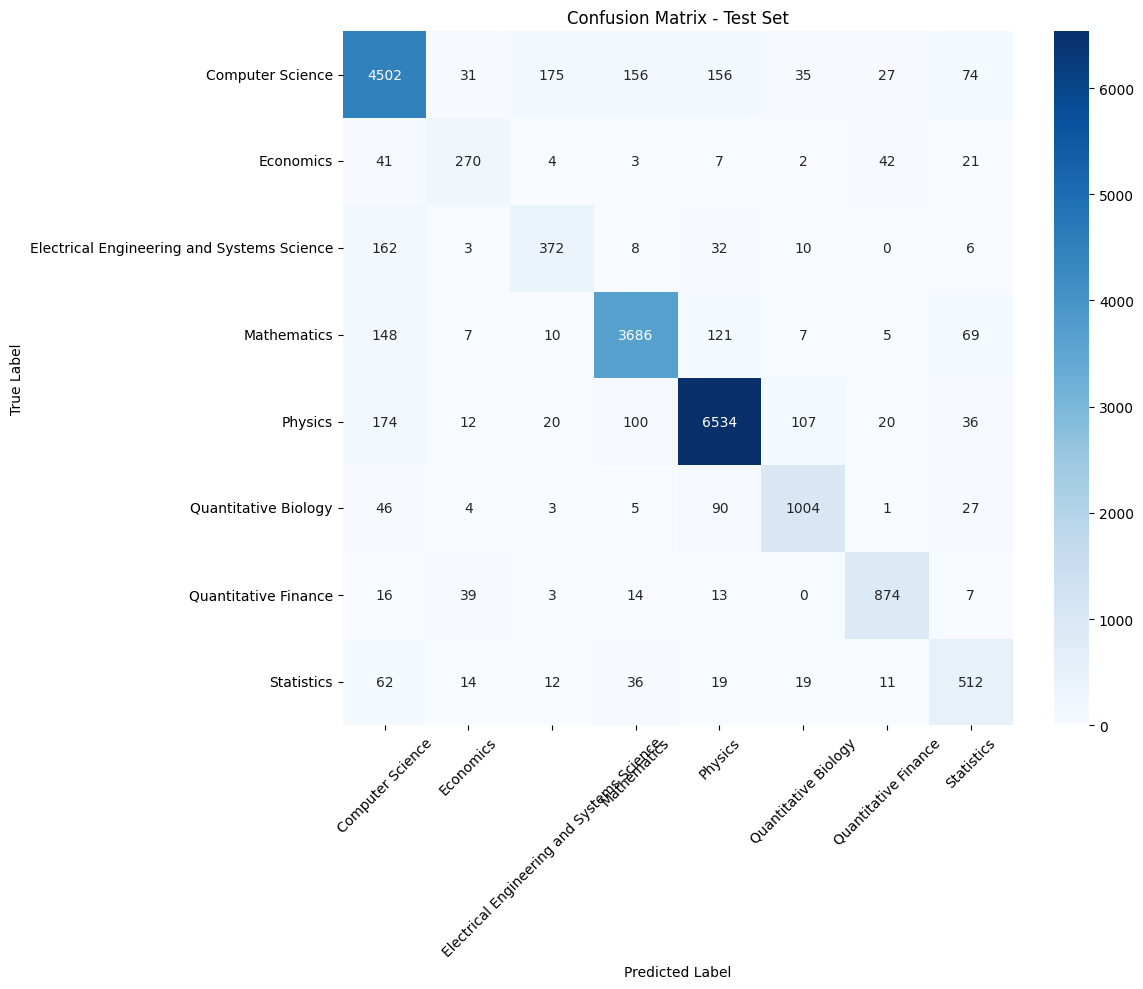

In [13]:
evaluate_model(trainer, train_dataset, test_dataset, data_processor.label_encoder)

In [14]:
# Zip the folder
!zip -r fine_tuned_model.zip fine_tuned_model

# Download it to your local machine
from google.colab import files
files.download('fine_tuned_model.zip')


  adding: fine_tuned_model/ (stored 0%)
  adding: fine_tuned_model/training_args.bin (deflated 52%)
  adding: fine_tuned_model/vocab.txt (deflated 53%)
  adding: fine_tuned_model/model.safetensors (deflated 8%)
  adding: fine_tuned_model/special_tokens_map.json (deflated 42%)
  adding: fine_tuned_model/tokenizer_config.json (deflated 75%)
  adding: fine_tuned_model/config.json (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>